In [5]:
# Notebook to analyze statistical proportionality hypothesis

In [1]:
from scipy.stats import spearmanr
from rlhfutils.rl_utils import bow_words
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-01-10 10:53:00,841] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:142: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [15]:
def countbow(blist, inlist, norm=False):
    bict = {}
    for b in blist:
        bict[b] = 0
        for s in inlist:
            if b in s:
                bict[b] = bict[b]+1
    # normalize to get a "probability"
    if norm: 
        val = sum(bict.values())
        tot = 0
        for b in bict.keys():
            bict[b] = bict[b]/len(inlist)
            tot+=bict[b]
        print(tot)
    return bict

def apresps(inlist):
    return [i.split("### Instruction:\n")[1] for i in inlist]

def compfuncts(chos, rej, ref, funct="sft"):
    if funct=="norm":
        if ref>0:
            return chos/ref - rej/ref
        else:
            return chos-rej
    if funct=="div":
        if chos>0:
            return rej/chos
        else:
            return rej
    if funct=="sub":
        return chos-rej
    if funct=="sft":
        return ref
    if funct=="chos":
        return chos
    if funct=="rej":
        return rej

def sort_dict_by_values(d):
    return sorted(d.items(), key=lambda x: x[1])

In [3]:
sftset = pd.read_json("../../outputs/origultragen.jsonl", lines=True, orient='records')
sftset['response'] = apresps(sftset['response'])
refratios = countbow(bow_words, sftset['response'], True)

2.0864661654135337


In [4]:
dsynth = Dataset.load_from_disk("../../data/bowtrunc/train100k/")

In [5]:
choseratios = countbow(bow_words, dsynth['response_j'], True)
rejratios = countbow(bow_words, dsynth['response_k'], True)

1.5825810011034203
0.29996321931320424


In [6]:
sort_dict_by_values(choseratios)

[('additionally', 6.687397599224261e-05),
 ('finally', 0.0020229377737653394),
 ('however', 0.005533821513358077),
 ('hope', 0.013366435951449493),
 ('ensure', 0.030720232721436452),
 ('generate', 0.031623031397331726),
 ('appropriate', 0.03202427525328518),
 ('contains', 0.040241415053331994),
 ('experience', 0.04273247065904303),
 ('include', 0.061381950713879696),
 ('important', 0.06605476978633765),
 ('safe', 0.06722506436620189),
 ('following', 0.07010064533386832),
 ('possible', 0.07473166817133113),
 ('first', 0.07633664359514494),
 ('two', 0.0873206941518708),
 ('best', 0.08744608285685626),
 ('example', 0.08768014177282911),
 ('data', 0.09471026849901361),
 ('code', 0.09524526030695155),
 ('respectful', 0.09802888955762865),
 ('understand', 0.11115290734610626),
 ('create', 0.1167034473534624),
 ('information', 0.1901310729929448)]

In [11]:
fname = "../../outputs/uncouts/uncoutbow1000.jsonl"
df = pd.read_json(fname, lines=True, orient='records')
df['response'] = apresps(df['response'])
oratios = countbow(bow_words, df['response'], True)
okeys = list(oratios.keys())

4.322916666666667


with rejected:  SignificanceResult(statistic=0.7979978801769607, pvalue=2.989350008874559e-06)
with chosen:  SignificanceResult(statistic=0.6806324183029299, pvalue=0.0002519110302974394)
chos - rej:  SignificanceResult(statistic=0.9127258138685198, pvalue=5.126478106039375e-10)


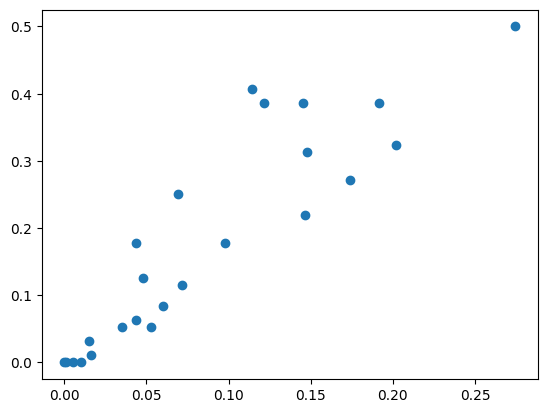

In [16]:
print("with rejected: ", spearmanr([rejratios[k] for k in okeys], [oratios[k] for k in okeys]))
print("with chosen: ", spearmanr([choseratios[k] for k in okeys], [oratios[k] for k in okeys]))
print("chos - rej: ", spearmanr([compfuncts(choseratios[k],rejratios[k],refratios[k]) for k in okeys], [oratios[k] for k in okeys]))
plt.scatter([compfuncts(choseratios[k],rejratios[k],refratios[k]) for k in okeys], [oratios[k] for k in okeys])